In [41]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer import Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import * 
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def HS_distance(U1, U2):
  n = 3 
  U1_dag = U1.adjoint().data
  U2 = U2.data
  tr = dot(U1_dag, U2).trace()
  # normalized
  distance = sqrt(1 - (1 / 2**(2*n)) * abs(tr)**2)
  return distance

Distance for Approx Toffoli: 0.3826834323651723


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


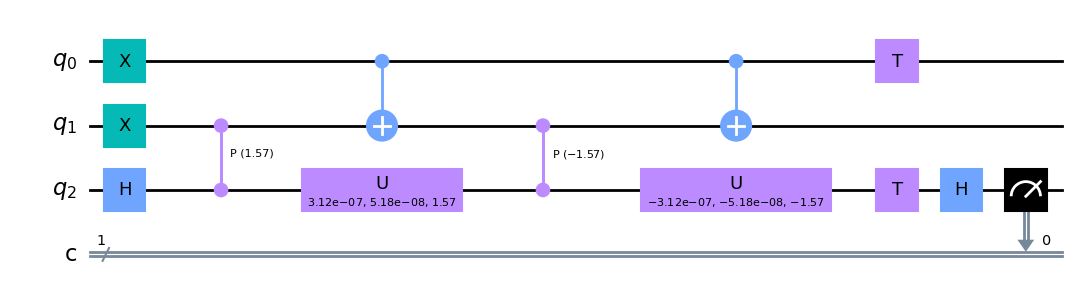

In [56]:
def approx_toffoli(qc, params):
    theta, phi, Lambda = params

    qc.h(2)
    #qc.cx(0, 1)
    qc.cp(Lambda, 1, 2)
    qc.u(theta, phi, Lambda, 2) 
    qc.cx(0, 1)
    qc.cp(-Lambda, 1, 2)
    qc.u(-theta, -phi, -Lambda, 2) 
    qc.cx(0, 1)

    qc.t(0)
    qc.t(2)

    qc.h(2)
    return qc

def approx_toffoli_optmized(params):
    toffoli = QuantumCircuit(3) #exact toffoli
    toffoli.ccx(0, 1, 2)
    toffoli_op = Operator(toffoli)

    # unitaries
    qc = QuantumCircuit(3, 1)
    approx_toffoli(qc, params)
    my_approx_op = Operator(qc)

#intreation for minimum distance
    n = HS_distance(my_approx_op, toffoli_op) 
    #intreation for minimum distance
    return n

initialization = array([0, 0, 0])

result = minimize(approx_toffoli_optmized, initialization, method='L-BFGS-B')

print("Distance for Approx Toffoli:", result.fun)
qc.draw(output='mpl')

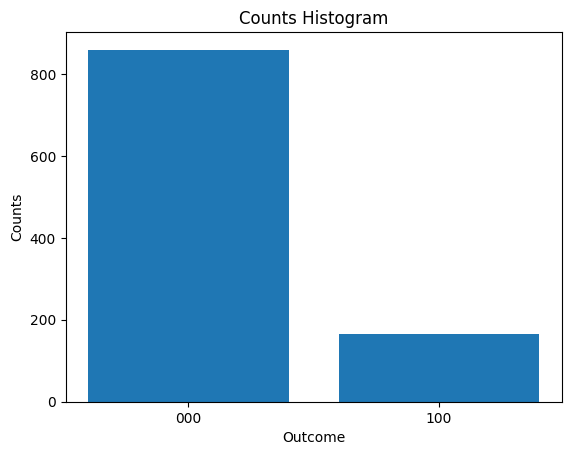

Counts Histogram for Approx Toffoli: {'100': 156, '000': 868}


In [57]:
def simulate_approx_toffoli(params, shots=1024):
    qc = QuantumCircuit(3, 3)
    approx_toffoli(qc, params)
    
    # Measure qubits
    qc.measure([0, 1, 2], [0, 1, 2])
    
    # Simulate the circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=shots)
    result = job.result()
    
    # Get counts
    counts = result.get_counts(qc)
    
    return counts

def plot_histogram(counts):
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Outcome')
    plt.ylabel('Counts')
    plt.title('Counts Histogram')
    plt.show()

plot_histogram(counts)

params = [0,0,0]  
counts = simulate_approx_toffoli(params)
print("Counts Histogram for Approx Toffoli:", counts)


In general, the HS Distance is defined as :

   $$
   \text{HS Distance} = d(\rho, \sigma) = \sqrt{\text{Tr}((\rho - \sigma)^2)}
   $$
   where $\rho$ and $\sigma$ are the density matrices of the two quantum operations. In our case, $\rho$ would represent the matrix of the Toffoli gate, and $\sigma$ the matrix of our approximated circuit.



The distance between two unitary operators $U_1$ and $U_2$ for a system of $n$ qubits is defined as:

$$
\text{HS Distance} = \sqrt{1 - \left(\frac{1}{2^{2n}}\right) \left|\text{Tr}(U_1^\dagger U_2)\right|^2}
$$



The provided code outlines a strategy to approximate the Toffoli gate using a combination of single-qubit and two-qubit gates. The approx_toffoli function defines the circuit, incorporating Hadamard (H), Controlled-Phase (CP), and CNOT gates to create an entangled state that resembles the action of the Toffoli gate on a three-qubit system.

This circuit starts with a Hadamard gate on the target qubit (C) to create superposition, followed by a sequence of gates designed to conditionally apply phase shifts and rotations based on the states of the control qubits (A and B). This sequence includes a Controlled-Phase gate (CP) that introduces a relative phase conditioned on the control qubits, and unitary rotations (U) that adjust the state of the target qubit based on the specified parameters (theta, phi, Lambda).

The objective is to find the set of parameters (theta, phi, Lambda) that minimizes the HS distance between the circuit's output and the ideal Toffoli gate. The HS_distance function calculates this distance, providing a measure of closeness between the two unitary operators.

The minimize function from an optimization library is used to find the optimal parameters that minimize the HS distance. This optimization process iteratively adjusts the parameters to converge towards a minimal distance, thereby approximating the Toffoli gate as closely as possible given the constraints.

We use Limited-memory BFGS Bound optimizer.
The target goal of Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound (L-BFGS-B) is to minimize the value of a differentiable scalar function $f$. This optimizer is a quasi-Newton method, meaning that, in contrast to Newtons’s method, it does not require $f's$ Hessian (the matrix of $f's$ second derivatives) when attempting to compute $f’s$ minimum value.

L-BFGS is an iterative method for solving unconstrained, non-linear optimization problems, but approximates BFGS using a limited amount of computer memory. L-BFGS starts with an initial estimate of the optimal value, and proceeds iteratively to refine that estimate with a sequence of better estimates.

We get the HS distance as 0.3826834323651723 as the one achieved by Porf Jens and group is 0.36